# Readout Mitigation



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit_experiments.library import MeasurementMitigation
# For simulation
from qiskit.providers.aer import AerSimulator
from qiskit.test.mock import FakeParis

from qiskit.result.mitigation.utils import (
    expval_with_stddev,
    str2diag,
    counts_probability_vector
)

backend = AerSimulator.from_backend(FakeParis())

In [2]:
SHOTS = 1024
qubits = [0,1,2,3]
num_qubits = len(qubits)

In [3]:
exp = MeasurementMitigation(qubits)
for c in exp.circuits():
    print(c)

         ░ ┌─┐         
   q_0: ─░─┤M├─────────
         ░ └╥┘┌─┐      
   q_1: ─░──╫─┤M├──────
         ░  ║ └╥┘┌─┐   
   q_2: ─░──╫──╫─┤M├───
         ░  ║  ║ └╥┘┌─┐
   q_3: ─░──╫──╫──╫─┤M├
         ░  ║  ║  ║ └╥┘
meas: 4/════╩══╩══╩══╩═
            0  1  2  3 
        ┌───┐ ░ ┌─┐         
   q_0: ┤ X ├─░─┤M├─────────
        ├───┤ ░ └╥┘┌─┐      
   q_1: ┤ X ├─░──╫─┤M├──────
        ├───┤ ░  ║ └╥┘┌─┐   
   q_2: ┤ X ├─░──╫──╫─┤M├───
        ├───┤ ░  ║  ║ └╥┘┌─┐
   q_3: ┤ X ├─░──╫──╫──╫─┤M├
        └───┘ ░  ║  ║  ║ └╥┘
meas: 4/═════════╩══╩══╩══╩═
                 0  1  2  3 


In [4]:
result = exp.run(backend).block_for_results()
mitigator = result.analysis_results(0).value

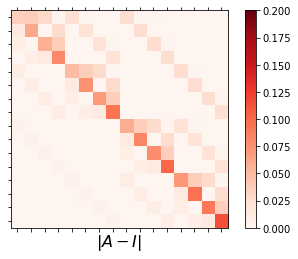

In [5]:
result.figure(0)

## Mitigation matrices

In [6]:
for m in mitigator._mitigation_mats:
    print(m)
    print()

[[ 1.01443299 -0.04123711]
 [-0.01443299  1.04123711]]

[[ 1.00913706 -0.03045685]
 [-0.00913706  1.03045685]]

[[ 1.01010101 -0.02424242]
 [-0.01010101  1.02424242]]

[[ 1.00504541 -0.02825429]
 [-0.00504541  1.02825429]]



## Mitigation Example

In [7]:
qc = QuantumCircuit(num_qubits)
qc.h(0)
for i in range(1, num_qubits):
    qc.cx(i - 1, i)
qc.measure_all()

In [8]:
counts = backend.run(qc, shots=SHOTS, seed_simulator=42, method="density_matrix").result().get_counts()
unmitigated_probs = {label: count / SHOTS for label, count in counts.items()}

In [9]:
mitigated_quasi_probs = mitigator.quasi_probabilities(counts)
mitigated_stddev = mitigated_quasi_probs._stddev_upper_bound
mitigated_probs = (mitigated_quasi_probs.nearest_probability_distribution().binary_probabilities())

### Probabilities

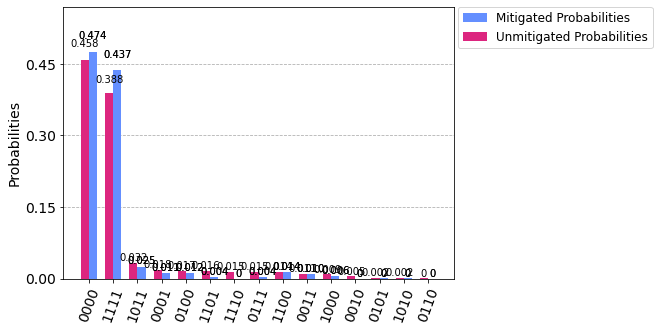

In [10]:
legend = ['Mitigated Probabilities', 'Unmitigated Probabilities']
plot_histogram([mitigated_probs, unmitigated_probs], legend=legend, sort="value_desc")

## Expectation value

In [11]:
diagonal_labels = ["ZZZZ", "ZIZI", "IZII", "1ZZ0"]
ideal_expectation = []
diagonals = [str2diag(d) for d in diagonal_labels]
qubit_index = {i: i for i in range(num_qubits)}
unmitigated_probs_vector, _ = counts_probability_vector(unmitigated_probs, qubit_index=qubit_index)
unmitigated_expectation = [expval_with_stddev(d, unmitigated_probs_vector, SHOTS) for d in diagonals]
mitigated_expectation = [mitigator.expectation_value(counts, d) for d in diagonals]

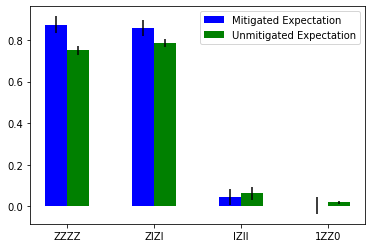

In [12]:
mitigated_expectation_values, mitigated_stddev = zip(*mitigated_expectation)
unmitigated_expectation_values, unmitigated_stddev = zip(*unmitigated_expectation)
legend = ['Mitigated Expectation', 'Unmitigated Expectation']
fig, ax = plt.subplots()
X = np.arange(4)
ax.bar(X + 0.00, mitigated_expectation_values, yerr=mitigated_stddev, color='b', width = 0.25, label="Mitigated Expectation")
ax.bar(X + 0.25, unmitigated_expectation_values, yerr=unmitigated_stddev, color='g', width = 0.25, label="Unmitigated Expectation")
ax.set_xticks([0.125 + i for i in range(len(diagonals))])
ax.set_xticklabels(diagonal_labels)
ax.legend()

In [13]:
qubits = [0,3]
num_qubits = len(qubits)
exp = MeasurementMitigation(qubits, method="correlated")
for c in exp.circuits():
    print(c)

         ░ ┌─┐   
   q_0: ─░─┤M├───
         ░ └╥┘┌─┐
   q_1: ─░──╫─┤M├
         ░  ║ └╥┘
meas: 2/════╩══╩═
            0  1 
        ┌───┐ ░ ┌─┐   
   q_0: ┤ X ├─░─┤M├───
        └───┘ ░ └╥┘┌─┐
   q_1: ──────░──╫─┤M├
              ░  ║ └╥┘
meas: 2/═════════╩══╩═
                 0  1 
              ░ ┌─┐   
   q_0: ──────░─┤M├───
        ┌───┐ ░ └╥┘┌─┐
   q_1: ┤ X ├─░──╫─┤M├
        └───┘ ░  ║ └╥┘
meas: 2/═════════╩══╩═
                 0  1 
        ┌───┐ ░ ┌─┐   
   q_0: ┤ X ├─░─┤M├───
        ├───┤ ░ └╥┘┌─┐
   q_1: ┤ X ├─░──╫─┤M├
        └───┘ ░  ║ └╥┘
meas: 2/═════════╩══╩═
                 0  1 


In [14]:
import qiskit.tools.jupyter
%qiskit_copyright